In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import trange
from sPINN import PINN, dydx, BONDI
import pandas as pd
from scipy.interpolate import interp1d
from scipy.special import hyp2f1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Legendre equation

In [2]:
# We start by setting the parameters of the equation and the integration grid

N= 50
xi = -1
xf = 1
x = np.linspace(xi, xf, N)
x_i = torch.tensor(x, dtype = torch.float32, requires_grad = True)

l = 3
initial_cond = (lambda num: -1 if num % 2 else 1)(l)

In [3]:
# We define the loss functions with the differential equation

def loss(y,x):
    
    z = initial_cond + (1-torch.exp(-(x-xi)))*y
    eq = (1-x**2)*dydx(z,x,2)-2*x*dydx(z,x,1)+l*(l+1)*z
    loss_v  = torch.mean(eq**2)   
    
    return loss_v

In [4]:
# We now set the network. 

hidden_sizes = [32 for i in range(4)] # Dimension of the hidden layers
legendre = PINN(hidden_sizes) # We call the module

legendre.set_integration_regime(N,xi,xf) # We set the parameters of the integration grid

optimizer = optim.Adam(legendre.parameters(), lr=1e-3, betas=(0.9,0.9)) #Note the first argument!
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 10000, T_mult=2)

legendre.set_trainer(optimizer, scheduler, loss) # We define optimizer and schedule and 
                                                # load them into the model together with the loss

In [11]:
legendre.train(x_i, epochs = 25000, target= 1e-10, res_step = 5000, resampling = True, schedule = True) 
# We train it

  0%|          | 0/25000 [00:00<?, ?it/s]

Epoch: 5000. Loss: 8.948840E-05. Learning rate: 6.168503E-12.
Epoch: 10000. Loss: 3.473127E-05. Learning rate: 9.619548E-04.
Epoch: 15000. Loss: 9.737105E-06. Learning rate: 8.535812E-04.
Epoch: 20000. Loss: 1.015578E-05. Learning rate: 6.913780E-04.
Epoch: 25000. Loss: 5.207020E-06. Learning rate: 5.000393E-04.
-------------------------------------
Finished after 25000 epochs. 
 Training loss: 5.207020E-06


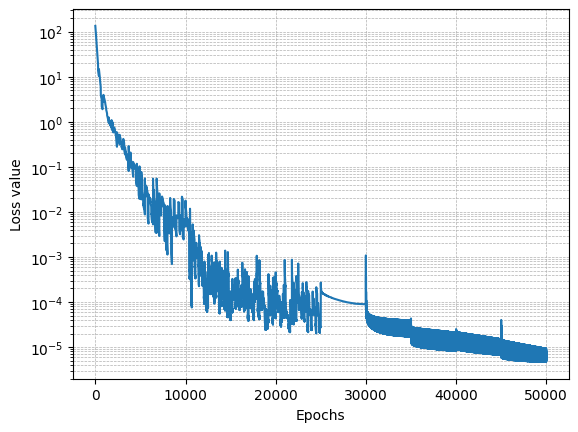

In [12]:
# PLot of the loss 
legendre.plot_loss_history()

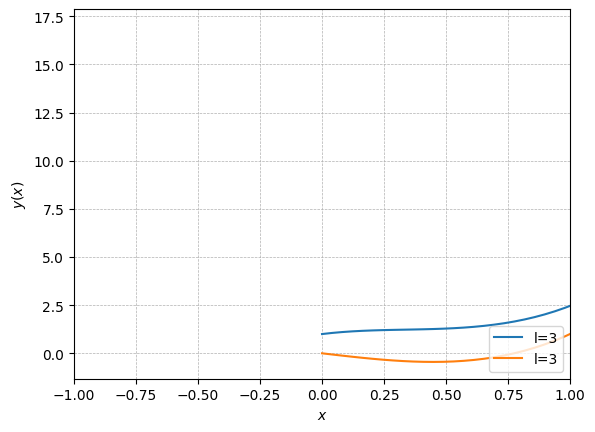

In [37]:
from scipy.special import legendre as le
yp = legendre(x_i).detach().numpy()
yp = initial_cond + (1-np.exp(-(x-xi)))*yp

plt.plot(x, yp, label=f"l={l}")
plt.plot(x, le(l)(x), label=f"l={l}")
plt.xlabel(r"$x$")
plt.ylabel(r"$y(x)$")
plt.grid(which='both', linestyle='--', linewidth=0.5)

plt.legend(loc="lower right")
plt.xlim(-1,1)
plt.show()

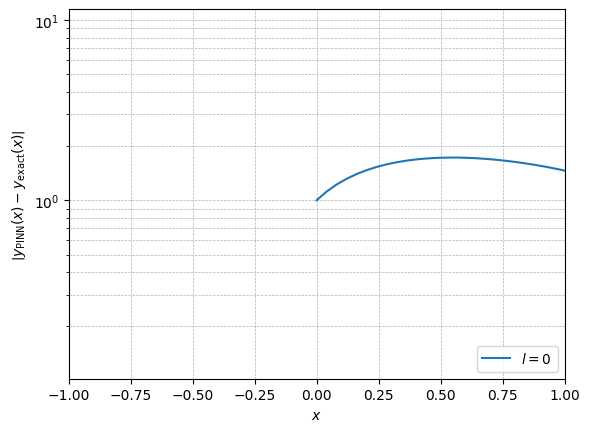

In [38]:
plt.semilogy(x, np.abs(yp-le(l)(x)), label=r"$l=0$")

plt.xlabel(r"$x$")
plt.ylabel(r"$\left|y_{\rm PINN}(x)-y_{\rm exact}(x)\right|$")
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.legend(loc="lower right")
plt.xlim(-1,1)

plt.show()

In [ ]:
# We set the network. 

hidden_sizes = [32 for i in range(2)] # Dimension of the hidden layers
aether = PINN(hidden_sizes) # We call the module

optimizer = optim.Adam(aether.parameters(), lr= 3e-4, betas=(0.9,0.9)) #Note the first argument!
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 50000, T_mult=2)
results ={}

In [ ]:
# We start by setting the parameters of the equation and the integration grid

# 0.2, 0.5, 1, 2, 10

N= 100
xi = 0
xf = 2
x = np.linspace(xi, xf, N)
x_i = torch.tensor(x, dtype = torch.float32, requires_grad = True)

c = 2

initial_cond = 1
aether.set_integration_regime(N,xi,xf) # We set the parameters of the integration grid

In [ ]:
# We define the loss functions with the differential equation

def loss(z,x):
    
    y = initial_cond+ (1-torch.exp((-x-xi)))*z
    y2 = dydx(y,x,2)
    y1 = dydx(y,x,1)
    
    P2 = y**2 -1 +x
    P1 = P2 - c**2*y**2
    
    eq =P1*P2*(x**2)*y2 +(c**2*y)*(-P2*x**2*y1**2 + x**2*(y*y1+1/2)**2+2*P2**2 )

    
    loss_v  = torch.mean(eq**2)   
    

    
    return loss_v

aether.set_trainer(optimizer, scheduler, loss)

In [ ]:
aether.train(x_i, epochs = 100000, target= 1e-10, res_step = 100, resampling = True, schedule = True) 
# We train it

In [ ]:
aether.plot_loss_history()

In [ ]:
# Saving for plotting

yp = aether(x_i).detach().numpy()
yp = initial_cond +(1-np.exp((-x-xi)))*yp

results[c] = yp

In [ ]:
for key in results.keys():
    plt.plot(x, results[key], label = "c=%s" % key)
    
plt.hlines(0, x[0], x[-1], colors="gray", linestyles='dotted')
plt.xlim(x[0],x[-1])
plt.legend()
plt.show()

In [ ]:
from scipy.optimize import root

def fun(x):
    x = torch.tensor(np.array([x]),dtype=torch.float32, requires_grad=True)
    y = aether(x).detach().numpy()
    x = x.detach().numpy()
    y = initial_cond +(1-np.exp(-(x-xi)))*y

    return y[0]

In [ ]:
root(fun, 1.5).x

In [ ]:
def eqs(model, x):
    x = torch.tensor(x, dtype = torch.float32, requires_grad = True)
    z = model(x)
    y = initial_cond +(1-torch.exp(-(x-xi)))*z
    y2 = dydx(y,x,2)
    y1 = dydx(y,x,1)
    
    P2 = y**2 -1 +x
    P1 = P2 - c**2*y**2
    
    eq =P1*P2*(x**2)*y2 +(c**2*y)*(-P2*x**2*y1**2 + x**2*(y*y1+1/2)**2+2*P2**2 )
    

    
    return eq.detach().numpy()

In [ ]:
plt.semilogy(x, eqs(aether,x))

# Hypergeometric Equation

In [15]:
# We now set the network. 

hidden_sizes = [64 for i in range(2)] # Dimension of the hidden layers
hyper = PINN(hidden_sizes) # We call the module

In [16]:
optimizer = optim.Adam(hyper.parameters(), lr= 3e-4, betas=(0.9,0.9)) #Note the first argument!
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 10000, T_mult=2)
results ={}

In [52]:
# We start by setting the parameters of the equation and the integration grid
N= 50
xi = 0
xf = 2
x = np.linspace(xi, xf, N)
x_i = torch.tensor(x, dtype = torch.float32, requires_grad = True)

a = -2
b = 1
c = 1

initial_cond = 1
hyper.set_integration_regime(N,xi,xf) # We set the parameters of the integration grid

In [53]:
# We define the loss functions with the differential equation

def loss(z,x):
    
    y = initial_cond +x*z
    y2 = dydx(y,x,2)
    y1 = dydx(y,x,1)
    
    eq =x*(1-x)*y2 + (c-(a+b+1)*x)*y1-a*b*y

    loss_v  = torch.mean(eq**2)   
    
    return loss_v

hyper.set_trainer(optimizer, scheduler, loss)

In [54]:
hyper.train(x_i, epochs = 25000, target= 4e-8, res_step = 5000, resampling = True, schedule = True) 

  0%|          | 0/25000 [00:00<?, ?it/s]

Epoch: 5000. Loss: 8.900718E-07. Learning rate: 1.196061E-05.
Epoch: 10000. Loss: 5.128965E-07. Learning rate: 6.551365E-09.
Epoch: 15000. Loss: 1.920416E-06. Learning rate: 2.972529E-04.
Epoch: 20000. Loss: 2.376430E-06. Learning rate: 2.888487E-04.
Epoch: 25000. Loss: 9.873503E-07. Learning rate: 2.751085E-04.
-------------------------------------
Finished after 25000 epochs. 
 Training loss: 9.873503E-07


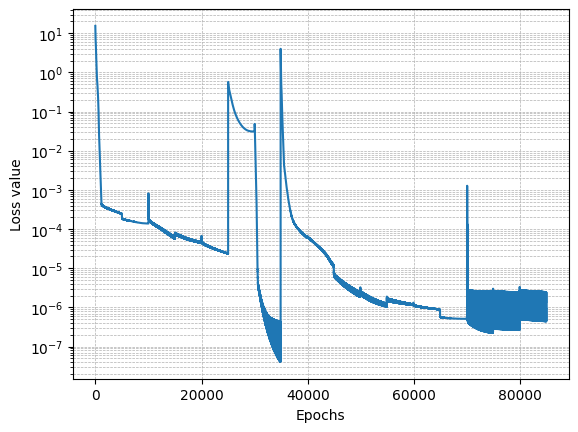

In [55]:
hyper.plot_loss_history()

In [56]:
# Plotting

yp = hyper(x_i).detach().numpy()
yp = initial_cond +x*yp
yr = np.array([hyp2f1(a,b,c,z) for z in x])

In [57]:
def eqs(model, x):
    x = torch.tensor(x, dtype = torch.float32, requires_grad = True)
    z = model(x)
    
    y = initial_cond +x*z
    y2 = dydx(y,x,2)
    y1 = dydx(y,x,1)
    eq =x*(1-x)*y2 + (c-(a+b+1)*x)*y1-a*b*y

    return eq.detach().numpy()

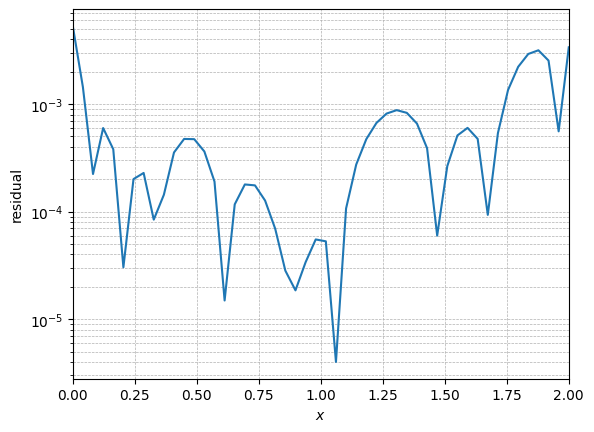

In [58]:
plt.semilogy(x,np.abs(eqs(hyper,x)))
plt.xlabel(r"$x$")
plt.ylabel(r"residual")
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.xlim(xi,xf)
plt.show()

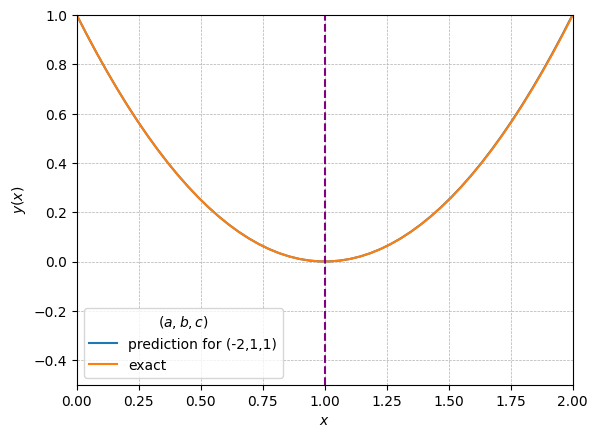

In [59]:
plt.plot(x, yp, label =f"prediction for ({a},{b},{c})")
plt.plot(x,yr, label = 'exact')
plt.xlabel(r"$x$")
plt.ylabel(r"$y(x)$")
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.axvline(1, color = 'purple', linestyle = '--')
plt.legend(loc="lower left", title = r"$(a,b,c)$")
plt.xlim(xi,xf)
plt.ylim(-0.5,1)
plt.show()

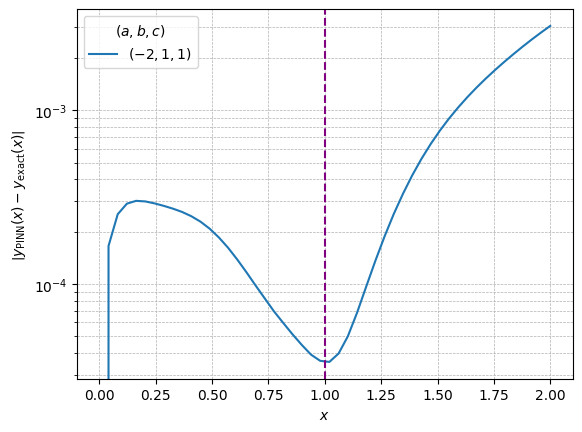

In [61]:
plt.semilogy(x, np.abs(yp-yr),label =f"$({a},{b},{c})$")

plt.xlabel(r"$x$")
plt.ylabel(r"$\left|y_{\rm PINN}(x)-y_{\rm exact}(x)\right|$")
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.axvline(1, color = 'purple', linestyle = '--')
plt.legend(loc="upper left", title = r"$(a,b,c)$")
plt.show()

# Bondi accretion

In [62]:
bondi = BONDI([256 for i in range(3)]) # We define the network

In [63]:
optimizer = optim.Adam(bondi.parameters(), lr= 3e-3, betas=(0.9,0.9)) #Note the first argument!
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 10000, T_mult=2)

In [64]:
def ev_eqs(rho0, v, x):
    
    drho0 = dydx(rho0,x,1)
    dv = dydx(v,x,1)
    
    eq1 = 2*v**2 + (M - M*v**2)/(2*M - x) + (drho0*(-(((-1 + Gamma)*Gamma*k*rho0**Gamma)/((-1 + Gamma)*rho0 + Gamma*k*rho0**Gamma)) + v**2)*x)/rho0
    
    eq2 = -(((-1 + Gamma)*rho0*v*(M*(-1 + v**2) + dv*v*(2*M - x)*x) + Gamma*k*rho0**Gamma*(dv*(-1 + Gamma - v**2)*x*(-2*M + x) + v*(-1 + v**2)*((-2 + 3*Gamma)*M - 2*(-1 + Gamma)*x)))/(((-1 + Gamma)*rho0 + Gamma*k*rho0**Gamma)*v*(-1 + v**2)*(2*M - x)))
    
    return eq1, eq2


def loss(ou,x, old_l1, old_l2):
    
    y = ou[0]
    z = ou[1]
    
    rhoin, vin = initial_cond
    
    rho0 = rhoin+(xi-x)/x*torch.exp(-y)
    v = torch.exp(-z)
    
    eq1, eq2 = ev_eqs(rho0, v, x)
  
    temp = 1e-6

    l1 = torch.mean(eq1**2)    
    l2 = torch.mean(eq2**2)  
    u1 = torch.clamp(temp*(l1-old_l1), max = 50)
    u2 = torch.clamp(temp*(l2-old_l2), max = 50)

    
    lambda1 = torch.exp(u1)
    lambda2 = torch.exp(u2)
    
    lambda1 = lambda1/(lambda1+lambda2)
    lambda2 = lambda2/(lambda1+lambda2)
    
    loss_v = lambda1*l1+lambda2*l2

    
    return loss_v, l1, l2

In [65]:
N= 1000
xi = 140.5
xf = 20
x = np.linspace(xi, xf, N)
x = torch.tensor(x, dtype = torch.float32, requires_grad = True)

k = 0.1
Gamma = 4/3
M = 1.0   
rho0_b = 0.000324197
v_b = 0.0286708
initial_cond = [rho0_b, v_b]

bondi.set_integration_regime(N,xi,xf) # We set the parameters of the integration grid
bondi.set_trainer(optimizer, scheduler, loss) # And the optimizer, etc...

In [66]:
bondi.train(x,10000, target= 1e-11, res_step = 2000, resampling = True, schedule = True) 

Training for 10000 epochs with learning rate 3.00E-03

-------------------------------------


  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 2000. Loss: 8.188133E-09. Learning rate: 2.713802E-03.
Epoch: 4000. Loss: 2.984152E-08. Learning rate: 1.963974E-03.
Epoch: 6000. Loss: 8.064264E-09. Learning rate: 1.036923E-03.
Epoch: 8000. Loss: 5.762256E-11. Learning rate: 2.867516E-04.
Epoch: 10000. Loss: 3.474581E-11. Learning rate: 7.402203E-11.
-------------------------------------
Finished after 10000 epochs. 
 Training loss: 3.474581E-11


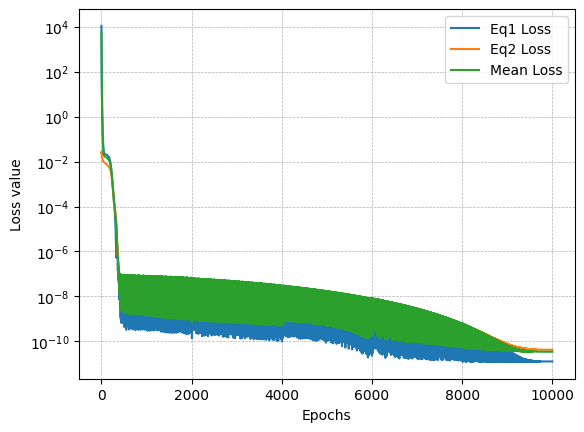

In [67]:
bondi.plot_loss_history()

### Visualizing results

In [68]:
yo, zo = bondi(x)
rhoin, vin = initial_cond
rhoo = rhoin+(xi-x)/x*torch.exp(-yo)
vo = torch.exp(-zo)
gammao = 1/torch.sqrt(1-vo**2)
yo = gammao*(1-2*M/x)
e1, e2 = ev_eqs(rhoo, vo, x)
C1 = rhoo*yo*vo*x**2
dc1 = dydx(C1,x,1)

e1 = e1.detach().numpy()
e2 = e2.detach().numpy()
rhoo = rhoo.detach().numpy()
vo = vo.detach().numpy()
yo = yo.detach().numpy()
r = x.detach().numpy()
C1 = C1.detach().numpy()
dc1 = dc1.detach().numpy()

In [73]:
# Load Enrico's data from file
file_path = './finite_diff_data/accretion.dat'
data = pd.read_csv(file_path, delim_whitespace=True, header=None)

#Save it into interpolators
rho_fd = interp1d(data[0], data[1])
v_fd = interp1d(data[0], data[2])
dx= np.abs(data[0][1]-data[0][0])


xp = np.array(data[0])
rho = np.array(data[1])
v = np.array(data[2])

drho = np.array([(-1/2 * rho[i-1]+1/2*rho[i+1])/dx   for i in range(1,len(rho)-1)])

dv =  np.array([(-1/2 * v[i-1]+1/2*v[i+1])/dx   for i in range(1,len(rho)-1)])

xp = xp[1:-1]
rho = rho[1:-1]
v = v[1:-1]
    
eq1_fd = 2*v**2 + (M - M*v**2)/(2*M - xp) + (drho*(-(((-1 + Gamma)*Gamma*k*rho**Gamma)/((-1 + Gamma)*rho + Gamma*k*rho**Gamma)) + v**2)*xp)/rho
    
    
eq2_fd = -(((-1 + Gamma)*rho*v*(M*(-1 + v**2) + dv*v*(2*M - xp)*xp) + Gamma*k*rho**Gamma*(dv*(-1 + Gamma - v**2)*xp*(-2*M + xp) + v*(-1 + v**2)*((-2 + 3*Gamma)*M - 2*(-1 + Gamma)*xp)))/(((-1 + Gamma)*rho + Gamma*k*rho**Gamma)*v*(-1 + v**2)*(2*M - xp)))
    


/tmp/ipykernel_1604/1097980599.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True, header=None)


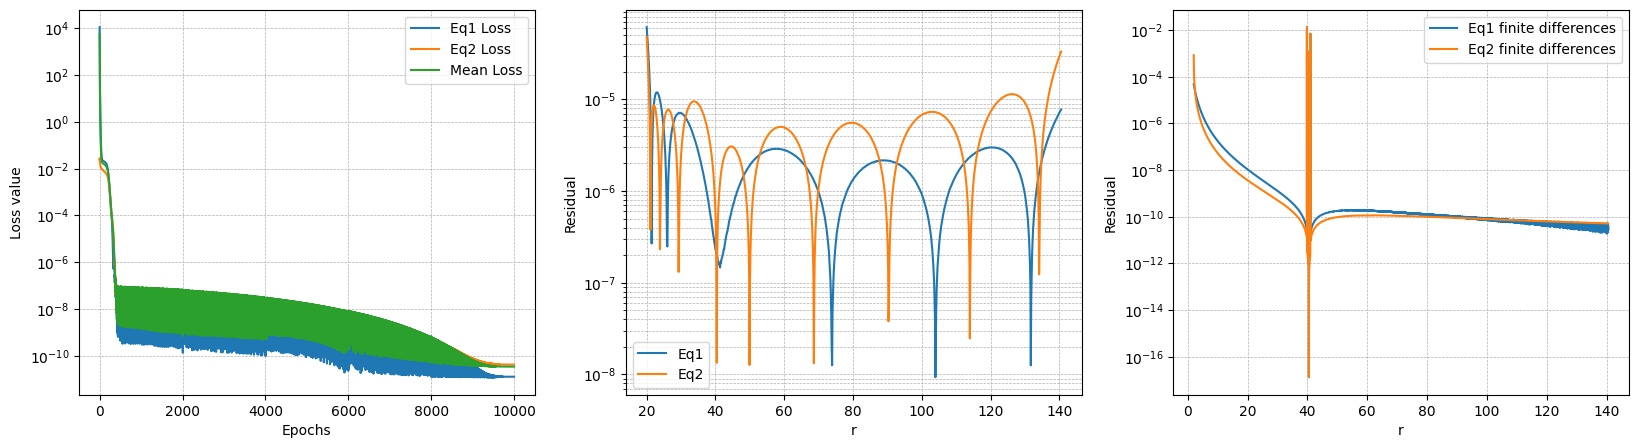

In [79]:
history = bondi.history
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,5))

ax1.semilogy(history["loss_1"], label = "Eq1 Loss")
ax1.semilogy(history["loss_2"], label = "Eq2 Loss")
ax1.semilogy(history["loss"], label = "Mean Loss")

ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss value")
ax1.grid(which='both', linestyle='--', linewidth=0.5)
ax1.legend()

ax2.semilogy(r, np.abs(e1), label = "Eq1")
ax2.semilogy(r, np.abs(e2), label = "Eq2")
ax2.grid(which='both', linestyle='--', linewidth=0.5)
ax2.set_xlabel("r")
ax2.set_ylabel("Residual")
ax2.legend()

ax3.semilogy(xp,np.abs(eq1_fd), label = "Eq1 finite differences")
ax3.semilogy(xp,np.abs(eq2_fd), label = "Eq2 finite differences")
ax3.grid(which='both', linestyle='--', linewidth=0.5)
ax3.set_xlabel("r")
ax3.set_ylabel("Residual")
ax3.legend()



plt.show()

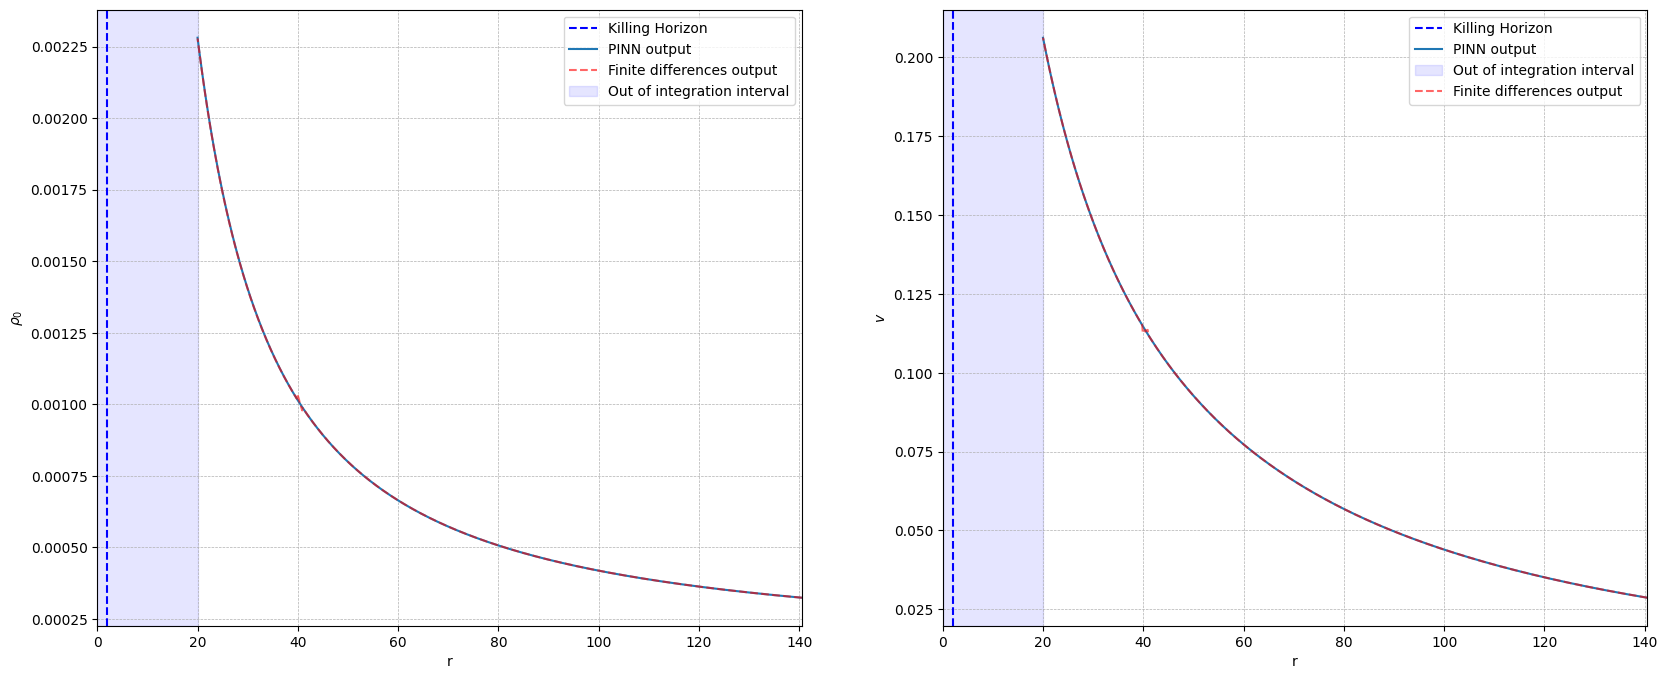

In [80]:
fig, ax = plt.subplots(1,2, figsize = (20,8))

ax[0].axvline(2*M, color = 'b', linestyle = '--', label = "Killing Horizon")

ax[0].plot(r, rhoo, label = "PINN output")

ax[0].plot(r, rho_fd(r),color='r', linestyle='dashed', alpha= 0.6,label = "Finite differences output")



ax[0].set_ylabel(r"$\rho_0$")
ax[0].set_xlabel("r")
ax[0].set_xlim(0,xi)
ax[0].grid(which='both', linestyle='--', linewidth=0.5)
ax[0].axvspan(0, xf , alpha=0.1, color='blue',label = "Out of integration interval")
ax[0].legend()

ax[1].axvline(2*M, color = 'b',linestyle = '--', label = "Killing Horizon")
ax[1].plot(r, vo, label = "PINN output")
ax[1].set_xlim(0,xi)
ax[1].axvspan(0, xf , alpha=0.1, color='blue',label = "Out of integration interval")
ax[1].plot(r, v_fd(r),color='r',linestyle='dashed', alpha= 0.6, label = "Finite differences output")

ax[1].set_ylabel(r"$v$")
ax[1].set_xlabel("r")

ax[1].grid(which='both', linestyle='--', linewidth=0.5)
ax[1].legend()

plt.show()

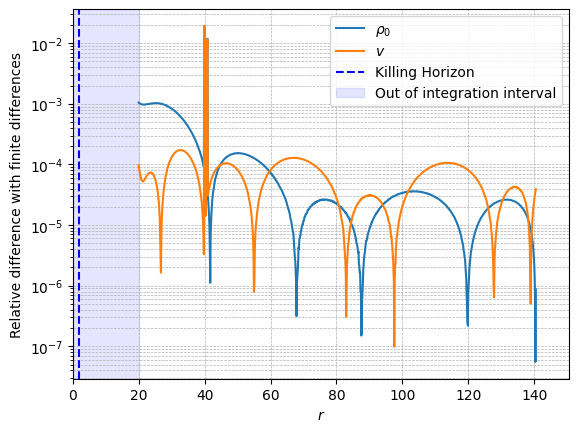

In [82]:
deltarho = np.abs((rhoo-rho_fd(r))/(rho_fd(r)))
deltav = np.abs((vo-v_fd(r))/(v_fd(r)))

plt.semilogy(r,deltarho, label = r"$\rho_0$")
plt.semilogy(r,deltav, label = r"$v$")
plt.axvline(2*M, color = 'b',linestyle = '--', label = "Killing Horizon")
plt.axvspan(0, xf , alpha=0.1, color='blue', label = "Out of integration interval")
plt.xlim(0,xi+10)
plt.xlabel(r"$r$")
plt.ylabel("Relative difference with finite differences")
plt.legend()
plt.grid(which='both', linestyle='--', linewidth=0.5)

plt.show()